In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 128

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 128)   768         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 128)   512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 128)   768         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 128)   512         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 128)   0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 128)   768         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 128)   512         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.9216 - acc: 0.3848
Epoch 00001: val_loss improved from inf to 3.54219, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_BN_4_conv_checkpoint/001-3.5422.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 3.9214 - acc: 0.3848 - val_loss: 3.5422 - val_acc: 0.3701
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6375 - acc: 0.5771
Epoch 00002: val_loss improved from 3.54219 to 3.10211, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_BN_4_conv_checkpoint/002-3.1021.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 2.6373 - acc: 0.5771 - val_loss: 3.1021 - val_acc: 0.5043
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3054 - acc: 0.6499
Epoch 00003: val_loss did not i

36800/36805 [============================>.] - ETA: 0s - loss: 1.3393 - acc: 0.8971
Epoch 00028: val_loss did not improve from 2.74313
36805/36805 [==============================] - 109s 3ms/sample - loss: 1.3394 - acc: 0.8971 - val_loss: 3.3506 - val_acc: 0.6594
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3567 - acc: 0.8923
Epoch 00029: val_loss did not improve from 2.74313
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.3566 - acc: 0.8923 - val_loss: 2.8071 - val_acc: 0.7126
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3504 - acc: 0.8949
Epoch 00030: val_loss did not improve from 2.74313
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.3508 - acc: 0.8948 - val_loss: 3.0353 - val_acc: 0.6865
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3452 - acc: 0.8976
Epoch 00031: val_loss did not improve from 2.74313
36805/36805 [=====================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6713 - acc: 0.9478
Epoch 00057: val_loss did not improve from 2.52054
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.6712 - acc: 0.9478 - val_loss: 2.6923 - val_acc: 0.7219
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6644 - acc: 0.9477
Epoch 00058: val_loss did not improve from 2.52054
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.6647 - acc: 0.9477 - val_loss: 2.7271 - val_acc: 0.7270
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6581 - acc: 0.9501
Epoch 00059: val_loss did not improve from 2.52054
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.6580 - acc: 0.9501 - val_loss: 2.7188 - val_acc: 0.7223
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6626 - acc: 0.9491
Epoch 00060: val_loss did not improve from 2.52054
36805/36805 [========

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6438 - acc: 0.9541
Epoch 00087: val_loss did not improve from 2.52054
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.6437 - acc: 0.9541 - val_loss: 2.7033 - val_acc: 0.7342
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6316 - acc: 0.9568
Epoch 00088: val_loss did not improve from 2.52054
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.6315 - acc: 0.9568 - val_loss: 2.7702 - val_acc: 0.7282
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6445 - acc: 0.9546
Epoch 00089: val_loss did not improve from 2.52054
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.6444 - acc: 0.9546 - val_loss: 2.5221 - val_acc: 0.7547
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6341 - acc: 0.9560
Epoch 00090: val_loss did not improve from 2.52054
36805/36805 [========

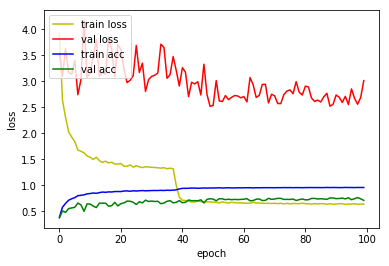

4815/4815 [==============================] - 5s 1ms/sample - loss: 2.8364 - acc: 0.6997
Loss: 2.836447862672657 Accuracy: 0.6996885

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9832 - acc: 0.4639
Epoch 00001: val_loss improved from inf to 1.66729, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_BN_5_conv_checkpoint/001-1.6673.hdf5
36805/36805 [==============================] - 113s 3ms/sample - loss: 1.9831 - acc: 0.4639 - val_loss: 1.6673 - val_acc: 0.4859
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1740 - acc: 0.6599
Epoch 00002: val_loss improved from 1.66729 to 0.96082, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_BN_5_conv_checkpoint/002-0.9608.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 1.1739 - acc: 0.6599 - val_loss: 0.9608 - val_acc: 0.7268
Epoch 3/500
36800/36805 [=================

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0993 - acc: 0.9700
Epoch 00028: val_loss did not improve from 0.84596
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0993 - acc: 0.9700 - val_loss: 0.9730 - val_acc: 0.8262
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1067 - acc: 0.9685
Epoch 00029: val_loss improved from 0.84596 to 0.79336, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_BN_5_conv_checkpoint/029-0.7934.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1068 - acc: 0.9684 - val_loss: 0.7934 - val_acc: 0.8586
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0816 - acc: 0.9754
Epoch 00030: val_loss did not improve from 0.79336
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0819 - acc: 0.9754 - val_loss: 1.1368 - val_acc: 0.8127
Epoch 31/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.0463 - acc: 0.9879
Epoch 00057: val_loss did not improve from 0.79336
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0463 - acc: 0.9879 - val_loss: 1.0090 - val_acc: 0.8465
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9876
Epoch 00058: val_loss did not improve from 0.79336
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0453 - acc: 0.9876 - val_loss: 0.9918 - val_acc: 0.8432
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9880
Epoch 00059: val_loss did not improve from 0.79336
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0450 - acc: 0.9880 - val_loss: 0.8436 - val_acc: 0.8656
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9877
Epoch 00060: val_loss did not improve from 0.79336
36805/36805 [=====================

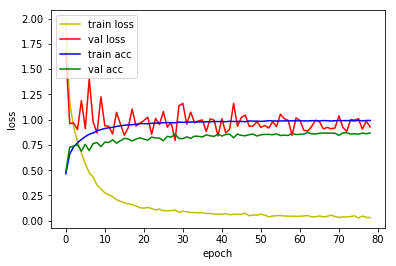

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.9248 - acc: 0.8280
Loss: 0.9247710018514472 Accuracy: 0.8280374

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8042 - acc: 0.4764
Epoch 00001: val_loss improved from inf to 1.24883, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_BN_6_conv_checkpoint/001-1.2488.hdf5
36805/36805 [==============================] - 116s 3ms/sample - loss: 1.8040 - acc: 0.4764 - val_loss: 1.2488 - val_acc: 0.6096
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0069 - acc: 0.6995
Epoch 00002: val_loss improved from 1.24883 to 0.92921, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_BN_6_conv_checkpoint/002-0.9292.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.0069 - acc: 0.6996 - val_loss: 0.9292 - val_acc: 0.7354
Epoch 3/500
36800/36805 [================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0786 - acc: 0.9740
Epoch 00027: val_loss did not improve from 0.33881
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0786 - acc: 0.9740 - val_loss: 0.4565 - val_acc: 0.8961
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0751 - acc: 0.9755
Epoch 00028: val_loss did not improve from 0.33881
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0751 - acc: 0.9754 - val_loss: 0.4110 - val_acc: 0.9159
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0767 - acc: 0.9752
Epoch 00029: val_loss did not improve from 0.33881
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0769 - acc: 0.9752 - val_loss: 0.4476 - val_acc: 0.9087
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0773 - acc: 0.9746
Epoch 00030: val_loss improved from 0.33881 to 0.31602, saving model to 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9885
Epoch 00056: val_loss did not improve from 0.31602
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0377 - acc: 0.9885 - val_loss: 0.3994 - val_acc: 0.9273
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9879
Epoch 00057: val_loss did not improve from 0.31602
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0398 - acc: 0.9879 - val_loss: 0.3199 - val_acc: 0.9420
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9910
Epoch 00058: val_loss did not improve from 0.31602
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0276 - acc: 0.9909 - val_loss: 0.3689 - val_acc: 0.9313
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.9873
Epoch 00059: val_loss did not improve from 0.31602
36805/36805 [=====================

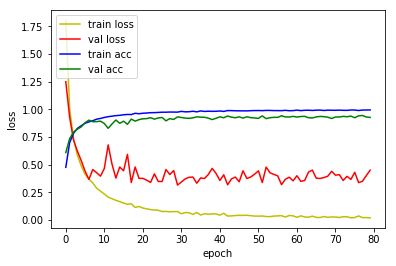

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3817 - acc: 0.9140
Loss: 0.3817043314717888 Accuracy: 0.9140187

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6833 - acc: 0.4951
Epoch 00001: val_loss improved from inf to 0.98153, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_BN_7_conv_checkpoint/001-0.9815.hdf5
36805/36805 [==============================] - 120s 3ms/sample - loss: 1.6834 - acc: 0.4951 - val_loss: 0.9815 - val_acc: 0.6967
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7609 - acc: 0.7710
Epoch 00002: val_loss improved from 0.98153 to 0.53793, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_BN_7_conv_checkpoint/002-0.5379.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.7608 - acc: 0.7710 - val_loss: 0.5379 - val_acc: 0.8367
Epoch 3/500
36800/36805 [================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9848
Epoch 00027: val_loss did not improve from 0.18947
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0447 - acc: 0.9848 - val_loss: 0.2102 - val_acc: 0.9485
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9832
Epoch 00028: val_loss improved from 0.18947 to 0.18351, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_BN_7_conv_checkpoint/028-0.1835.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0479 - acc: 0.9832 - val_loss: 0.1835 - val_acc: 0.9536
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9879
Epoch 00029: val_loss did not improve from 0.18351
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0372 - acc: 0.9879 - val_loss: 0.2183 - val_acc: 0.9469
Epoch 30/500
36800/36805 [============================>

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9949
Epoch 00056: val_loss did not improve from 0.18135
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0143 - acc: 0.9949 - val_loss: 0.2612 - val_acc: 0.9495
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0138 - acc: 0.9957
Epoch 00057: val_loss did not improve from 0.18135
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0138 - acc: 0.9957 - val_loss: 0.2845 - val_acc: 0.9457
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9924
Epoch 00058: val_loss did not improve from 0.18135
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0227 - acc: 0.9924 - val_loss: 0.2161 - val_acc: 0.9620
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9956
Epoch 00059: val_loss did not improve from 0.18135
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9951
Epoch 00085: val_loss did not improve from 0.17947
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0152 - acc: 0.9950 - val_loss: 0.2884 - val_acc: 0.9481
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0190 - acc: 0.9943
Epoch 00086: val_loss did not improve from 0.17947
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0190 - acc: 0.9943 - val_loss: 0.1805 - val_acc: 0.9653
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0108 - acc: 0.9960
Epoch 00087: val_loss did not improve from 0.17947
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0108 - acc: 0.9960 - val_loss: 0.2084 - val_acc: 0.9599
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9959
Epoch 00088: val_loss did not improve from 0.17947
36805/36805 [=====================

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9976
Epoch 00115: val_loss did not improve from 0.17947
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0079 - acc: 0.9976 - val_loss: 0.1908 - val_acc: 0.9669
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9961
Epoch 00116: val_loss did not improve from 0.17947
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0130 - acc: 0.9961 - val_loss: 0.2179 - val_acc: 0.9630
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0068 - acc: 0.9977
Epoch 00117: val_loss did not improve from 0.17947
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0068 - acc: 0.9977 - val_loss: 0.2269 - val_acc: 0.9646

1D_CNN_custom_multi_3_concat_ch_128_DO_BN_7_conv Model


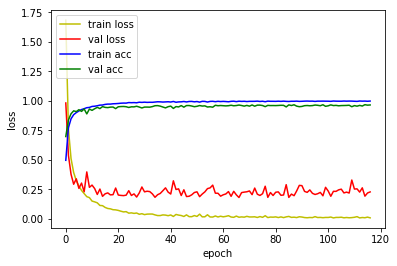

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2447 - acc: 0.9483
Loss: 0.24473613623755974 Accuracy: 0.9482866

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5685 - acc: 0.5268
Epoch 00001: val_loss improved from inf to 0.90304, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_BN_8_conv_checkpoint/001-0.9030.hdf5
36805/36805 [==============================] - 125s 3ms/sample - loss: 1.5683 - acc: 0.5268 - val_loss: 0.9030 - val_acc: 0.7133
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6146 - acc: 0.8107
Epoch 00002: val_loss improved from 0.90304 to 0.35476, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_BN_8_conv_checkpoint/002-0.3548.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.6147 - acc: 0.8107 - val_loss: 0.3548 - val_acc: 0.8980
Epoch 3/500
36800/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9866
Epoch 00025: val_loss did not improve from 0.13612
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0409 - acc: 0.9866 - val_loss: 0.1408 - val_acc: 0.9637
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9887
Epoch 00026: val_loss did not improve from 0.13612
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0352 - acc: 0.9887 - val_loss: 0.1811 - val_acc: 0.9527
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9886
Epoch 00027: val_loss did not improve from 0.13612
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0357 - acc: 0.9885 - val_loss: 0.1514 - val_acc: 0.9599
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9892
Epoch 00028: val_loss did not improve from 0.13612
36805/36805 [=====================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9921
Epoch 00055: val_loss did not improve from 0.13612
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0234 - acc: 0.9921 - val_loss: 0.1626 - val_acc: 0.9644
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9976
Epoch 00056: val_loss did not improve from 0.13612
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0079 - acc: 0.9976 - val_loss: 0.1654 - val_acc: 0.9644
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9923
Epoch 00057: val_loss did not improve from 0.13612
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0256 - acc: 0.9923 - val_loss: 0.1680 - val_acc: 0.9639
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9964
Epoch 00058: val_loss did not improve from 0.13612
36805/36805 [========

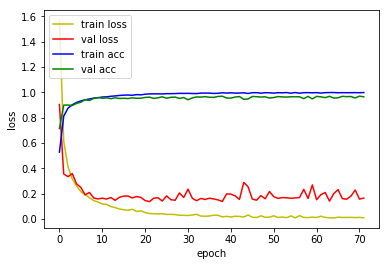

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1794 - acc: 0.9518
Loss: 0.17936863774513034 Accuracy: 0.9518172



In [10]:
base = '1D_CNN_custom_multi_3_concat_ch_128_DO_BN'

for i in range(4, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_concat_ch_128_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_concat_ch_128_DO_BN_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_33[0][0]  
_____________________________________________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.9248 - acc: 0.8280
Loss: 0.9247710018514472 Accuracy: 0.8280374

1D_CNN_custom_multi_3_concat_ch_128_DO_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_42 (Batc (None, 16000, 128)   512         conv1d_42[0][0]                  
__________________________________________________________________________________________________
activation_42 (Acti

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2447 - acc: 0.9483
Loss: 0.24473613623755974 Accuracy: 0.9482866

1D_CNN_custom_multi_3_concat_ch_128_DO_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_55 (Batc (None, 16000, 128)   512         conv1d_55[0][0]                  
__________________________________________________________________________________________________
activation_55 (Act

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1794 - acc: 0.9518
Loss: 0.17936863774513034 Accuracy: 0.9518172


In [12]:
for i in range(4, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_3_concat_ch_128_DO_BN_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_33[0][0]  
_____________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.1233 - acc: 0.8370
Loss: 1.1233408542997896 Accuracy: 0.8369678

1D_CNN_custom_multi_3_concat_ch_128_DO_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_42 (Batc (None, 16000, 128)   512         conv1d_42[0][0]                  
__________________________________________________________________________________________________
activation_42 (Acti

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2870 - acc: 0.9472
Loss: 0.2870340168372776 Accuracy: 0.94724816

1D_CNN_custom_multi_3_concat_ch_128_DO_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_55 (Batc (None, 16000, 128)   512         conv1d_55[0][0]                  
__________________________________________________________________________________________________
activation_55 (Act

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2561 - acc: 0.9472
Loss: 0.2560636434481148 Accuracy: 0.94724816
